In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import warnings

In [2]:

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Parameters
test_size = 0.30
random_state = 42
cv_folds = 5

In [3]:
df = pd.read_json('../data/sp500_constituents.json')
print(f"Original dataset shape: {df.shape}")

Original dataset shape: (503, 183)


In [4]:
sector_counts = df['sector'].value_counts()
print(sector_counts)

sector
Technology                82
Industrials               70
Financial Services        67
Healthcare                62
Consumer Cyclical         55
Consumer Defensive        36
Utilities                 32
Real Estate               31
Basic Materials           22
Communication Services    22
Energy                    22
Name: count, dtype: int64


In [5]:
target_sectors = ['Technology', 'Utilities']
df_filtered = df[df['sector'].isin(target_sectors)].copy()

In [6]:
filtered_counts = df_filtered['sector'].value_counts()
print(filtered_counts)

sector
Technology    82
Utilities     32
Name: count, dtype: int64


In [7]:
required_vars = ['sector', 'profitMargins', 'beta', 'debtToEquity', 
                'returnOnAssets', 'returnOnEquity', 'priceToBook']
df_final = df_filtered[required_vars].copy()


In [8]:
# Prepare features and target
X = df_final.drop('sector', axis=1)
y = df_final['sector']
print(y.value_counts())
print(X.describe())

sector
Technology    82
Utilities     32
Name: count, dtype: int64
       profitMargins        beta  debtToEquity  returnOnAssets  \
count     114.000000  113.000000    106.000000      112.000000   
mean        0.170350    1.048938    113.661830        0.072299   
std         0.122633    0.356415    116.109969        0.076356   
min        -0.353210    0.381000      0.597000       -0.012330   
25%         0.108300    0.806000     31.547000        0.028580   
50%         0.149740    1.050000     76.872000        0.050990   
75%         0.221578    1.244000    167.750750        0.088728   
max         0.809520    2.811000    699.241000        0.591310   

       returnOnEquity  priceToBook  
count      109.000000   114.000000  
mean         0.306386     7.684550  
std          0.476086    13.525114  
min         -0.178910   -37.200413  
25%          0.090770     2.282635  
50%          0.134580     4.622190  
75%          0.301680     9.724875  
max          3.387420    55.795690  


In [9]:
# Create stratified train-test split (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    stratify=y, 
    random_state=random_state
)
print(y_train.value_counts())
print(y_test.value_counts())

sector
Technology    57
Utilities     22
Name: count, dtype: int64
sector
Technology    25
Utilities     10
Name: count, dtype: int64


In [10]:
# Define hyperparameter grid
param_grid = {
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
total_combinations = (len(param_grid['max_depth']) * 
                     len(param_grid['min_samples_split']) * 
                     len(param_grid['min_samples_leaf']) * 
                     len(param_grid['criterion']))
print(f"max_depth: {param_grid['max_depth']}")
print(f"min_samples_split: {param_grid['min_samples_split']}")
print(f"✓ min_samples_leaf: {param_grid['min_samples_leaf']}")
print(f"✓ criterion: {param_grid['criterion']}")
print(f"✓ Total parameter combinations: {total_combinations}")

max_depth: [1, 2, 3]
min_samples_split: [2, 5, 10]
✓ min_samples_leaf: [1, 2, 4]
✓ criterion: ['gini', 'entropy']
✓ Total parameter combinations: 54


In [19]:
# Create Decision Tree Classifier and perform Grid Search
dt_classifier = DecisionTreeClassifier(random_state=random_state)

grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    cv=cv_folds,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

In [20]:
grid_search.fit(X_train, y_train)
# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [21]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[24  1]
 [ 1  9]]


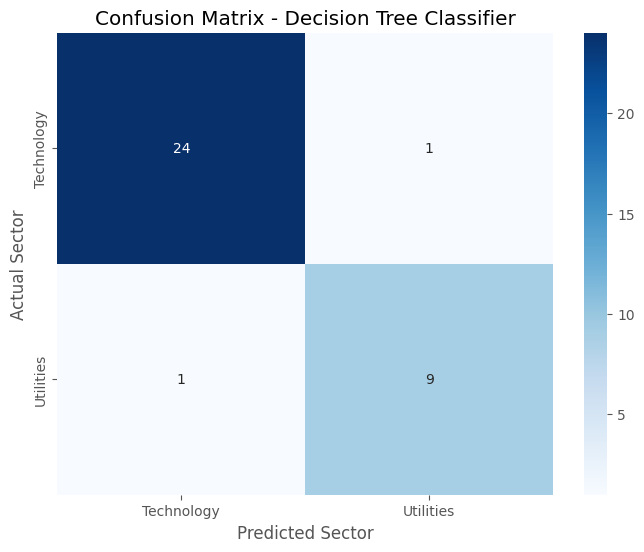

In [23]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Technology', 'Utilities'], 
            yticklabels=['Technology', 'Utilities'])
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.xlabel('Predicted Sector')
plt.ylabel('Actual Sector')
plt.show()

### 3.a Confusion matrix result:
As we can see from the heatmap, the model is very accurate. Out of 35 companies, 24 are correctly idenitfied as Technology sector, 9 are correctly identified as Utilities sector. And only 1 company from Technology sector is predicted as Utilities, and 1 company from Utilities sector is predicted as Technology.

In [24]:
# Classification Report
print(classification_report(y_test, y_pred))
class_report = classification_report(y_test, y_pred, output_dict=True)

              precision    recall  f1-score   support

  Technology       0.96      0.96      0.96        25
   Utilities       0.90      0.90      0.90        10

    accuracy                           0.94        35
   macro avg       0.93      0.93      0.93        35
weighted avg       0.94      0.94      0.94        35



### 3.b Classification Report result:
#### Technology Sector

- Precision: 0.96.
- Recall: 0.96
- F1-Score: 0.96

It has a 96% success rate to predict a sector to be Technology; And it correctly identifies 96% of all Tech companies. Hence the F1 score is also 96%.


#### Utilities Sector

- Precision: 0.90
- Recall: 0.90
- F1-Score: 0.90

It has a 90% success rate to predict a sector to be Utilities; And it correctly identifies 90% of all Utilities companies. Hence the F1 score is also 90%.

#### Overall Performance

- Accuracy: 94%.
- Macro Average: 0.93.
- Weighted Average: 0.94.

Out of all 35 companies, the model correctly classified about 33 of them. And we can see both the Macro Average and Weighted Average are pretty good.

In [25]:
# Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)

In [26]:
for i, (feature, importance) in enumerate(feature_importance_sorted.items(), 1):
    print(f"{i}. {feature}: {importance:.4f}")

1. returnOnAssets: 0.6355
2. beta: 0.3645
3. profitMargins: 0.0000
4. debtToEquity: 0.0000
5. returnOnEquity: 0.0000
6. priceToBook: 0.0000


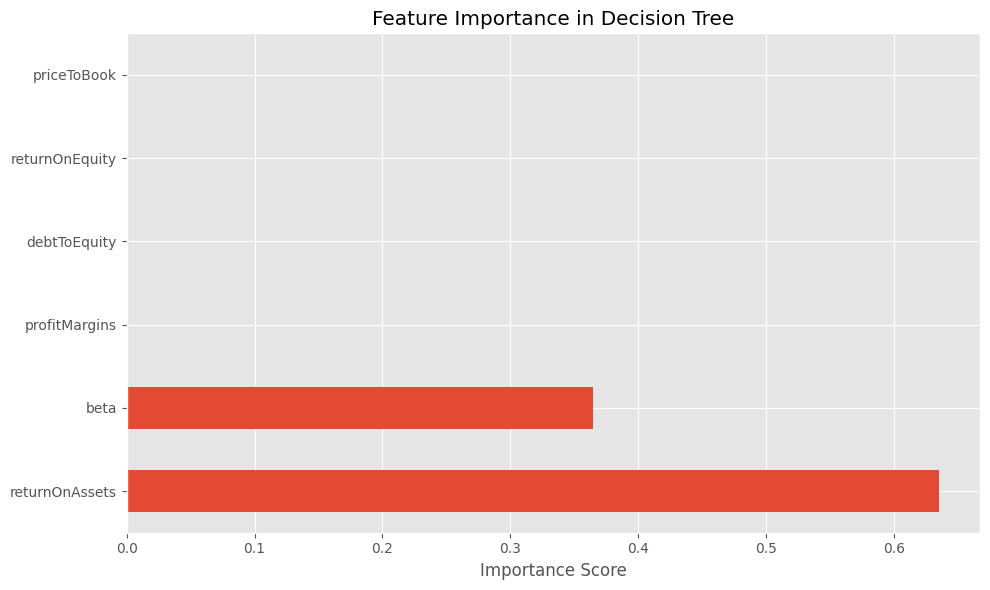

In [27]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance_sorted.plot(kind='barh')
plt.title('Feature Importance in Decision Tree')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


2. DECISION TREE VISUALIZATION:
------------------------------


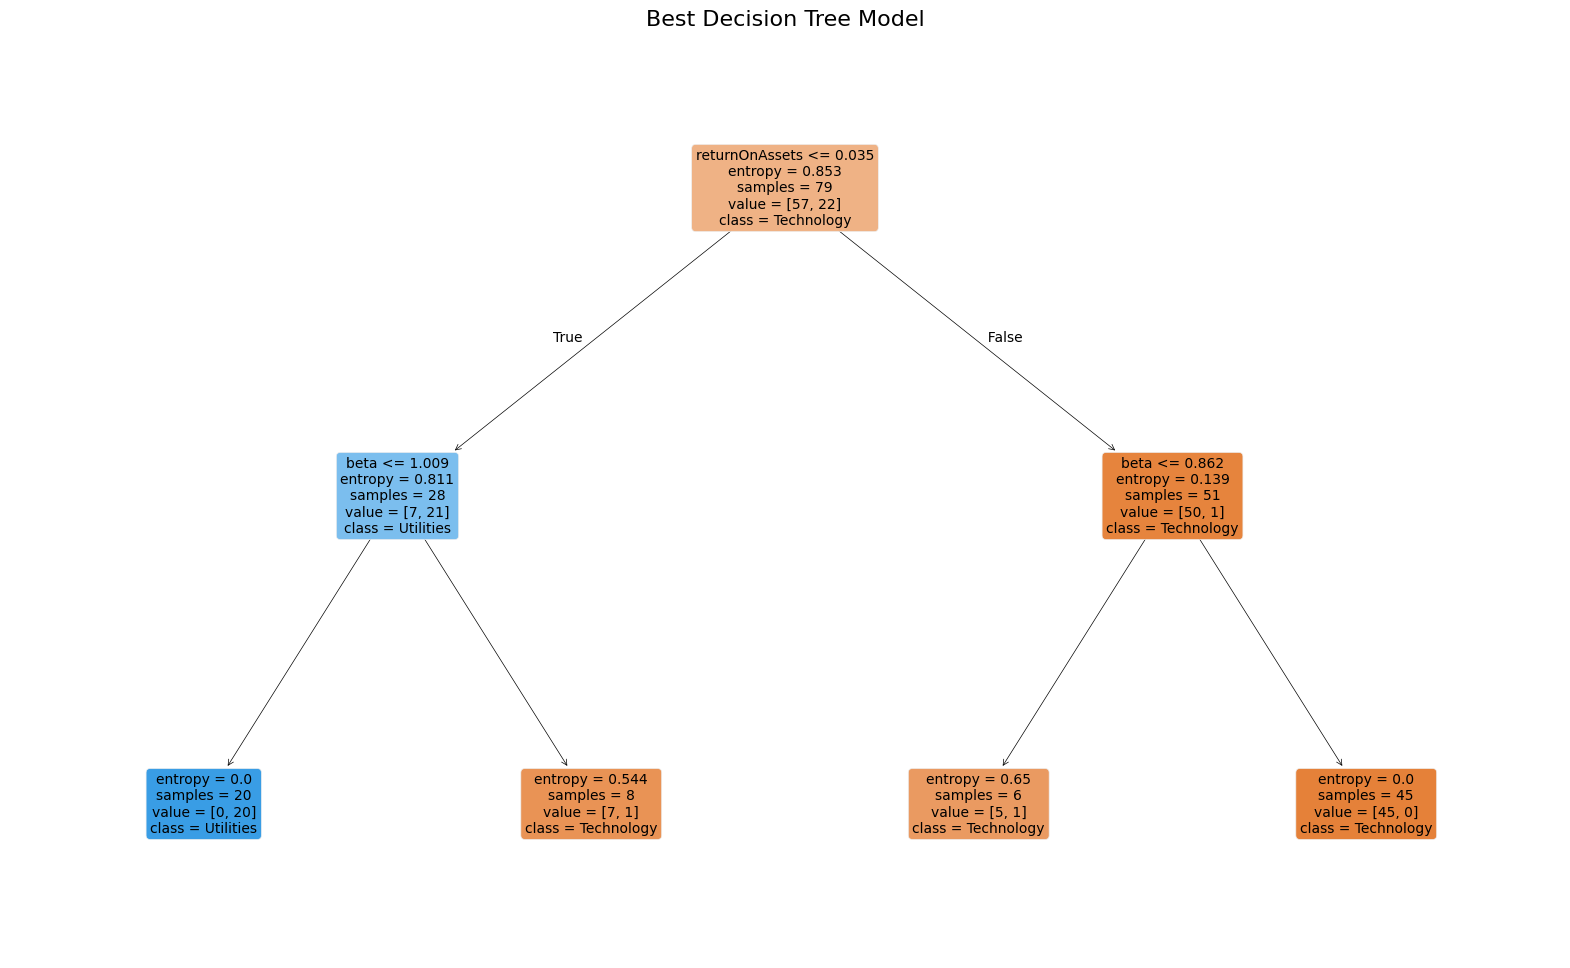

In [28]:
# Visualize the Decision Tree
print("\n2. DECISION TREE VISUALIZATION:")
print("-" * 30)
plt.figure(figsize=(20, 12))
plot_tree(best_model, 
          feature_names=list(X.columns), 
          class_names=['Technology', 'Utilities'],
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title('Best Decision Tree Model', fontsize=16)
plt.show()

In [29]:
tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules[:1000])

|--- returnOnAssets <= 0.04
|   |--- beta <= 1.01
|   |   |--- class: Utilities
|   |--- beta >  1.01
|   |   |--- class: Technology
|--- returnOnAssets >  0.04
|   |--- beta <= 0.86
|   |   |--- class: Technology
|   |--- beta >  0.86
|   |   |--- class: Technology



In [34]:
# Sector Analysis for Investment Perspective
sector_stats = df_final.groupby('sector')[X.columns].mean()

In [ ]:
tech_avg = sector_stats.loc['Technology']
for metric in X.columns:
    print(f"{metric}: {tech_avg[metric]}")

profitMargins: 0.18309243951219514
beta: 1.1863536585365855
debtToEquity: 91.16841891891892
returnOnAssets: 0.08788499976463415
returnOnEquity: 0.3868445457272727
priceToBook: 9.445883198780487


In [36]:
util_avg = sector_stats.loc['Utilities']  
for metric in X.columns:
    print(f"{metric}: {util_avg[metric]}")

profitMargins: 0.137698124375
beta: 0.6854516129032258
debtToEquity: 165.67784375
returnOnAssets: 0.02969599976666667
returnOnEquity: 0.11278093771875
priceToBook: 3.17113350625


### 4.a Decision tree interpretation
The visualized tree shows the simple, rule-based logic the model uses to classify companies. The two most important features it automatically selected are Return on Assets (returnOnAssets) and Beta (beta). 
The decision logic is based on a couple of params or features: First is `returnOnAssets <= 0.035`.
If the returnOnAssets is low (`<= 0.035`) AND the beta is also low (`<= 1.009`), the model classifies it as a Utilities company.
If the returnOnAssets is high (`> 0.035`) AND the beta is also high (`> 0.862`), the model classifies it as a Technology company.

#### Which sector appears more attractive from an investor’s perspective?
The Technology sector seems more attractive because of the following reasons:
- Higher Returns: The tree's primary splitter, returnOnAssets, is higher for Technology (`0.088`) than Utilities (`0.030`). Technology stocks also have higher profitMargins and returnOnEquity.
- Growth Potential: Technology companies have a much higher average priceToBook ratio (`9.445883198780487 vs 3.17113350625`)

### 4.b Why might someone prefer the Decision Tree Classifier over Random Forests or Gradient Boosting Trees?
Random Forests or Gradient Boosting are often more accurate. However, Decision Tree is much easier to visualize the steps, and its very easy to explain. For example in my workplace, banking sector, the regulators have very strict policy to enforce the traceability and explainability. If some bug occurs, we need to understand which part has gone wrong, and why it has gone wrong.